In [1]:
import numpy as np
import pandas as pd
import triflow as tf
import pylab as pl
from path import Path
from matplotlib.tri import Triangulation
from scipy.integrate import cumtrapz
from th_fallfilm.misc import helpers, container, materials
import multiprocessing as mp
from scibelt.viz import cascade_plot
pl.style.use('publication_jupyter')

%matplotlib inline

## Modélisation hydrodynamique

### Modèle

In [2]:
func = ["-dxq",
        """((378 * dxxq * h**2 +
           336 * dxh**2 * q - 210 * (q + 2 * dxs**2 * q) -
           9 * h * q * (56 * dxxh + 35 * dxxs + 68 * dxq * Re) -
           2 * dxh * (189 * dxq * h + 35 * Ct * h**3 +
                      3 * q * (35 * dxs - 54 * q * Re)) +
           70 * h**3 * (1 - Ct * dxs +
                        (dxxxh + dxxxs) * We)) / (252. * h**2 * Re))"""]
var = ["h", "q"]
pars = ["Re", "Ct", "We"]
fields = "s"
hydro_model = tf.Model(func, var, pars, fields)

### Conditions initiales

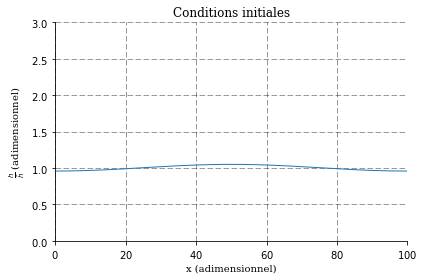

In [3]:
x = np.linspace(0, 100, 1200)
h = helpers.make_initial_wave(x, .1, 1)

q = h ** 3 / 3
init_fields = hydro_model.fields_template(x=x, h=h, q=q, s=x*0)

parameters = materials.water()
parameters['Re'] = 20
parameters['Ct'] = 0
parameters['periodic'] = True

pl.plot(x, h)
pl.xlim(x.min(), x.max())
pl.ylim(0, 3)
pl.legend()
pl.title('Conditions initiales')
pl.xlabel('x (adimensionnel)')
pl.ylabel(r"$\frac{h}{\bar{h}}$ (adimensionnel)")
pl.show()

### Lancement de la simulation

In [4]:
t = 0
fields = init_fields

noisy = tf.signals.GaussianBrownNoise(.1, frequency_cut=.05)


simul = tf.Simulation(hydro_model, t, fields, parameters, dt=1, tol=1E-1,
                      tmax=600)

simul.add_display(tf.displays.bokeh_fields_update, ['h'], 
                  fig_kwargs={"h":
                              {"width": 600,
                               "height": 200,
                               "x_range": (x.min(), x.max()),
                               "y_range": (0, 3)}})

persist = container.TreantContainer('data/periodic_wave',
                                    initial_fields=init_fields,
                                    metadata=parameters,
                                    clean=True)
for t, fields in simul:
    persist.append(t, fields)
    print(f"{t:g}".ljust(80), end='\r')

Loading BokehJS ...

### Post traitement

In [36]:
persist = container.TreantContainer('data/periodic_wave')

#### Graphe spatio-temporel

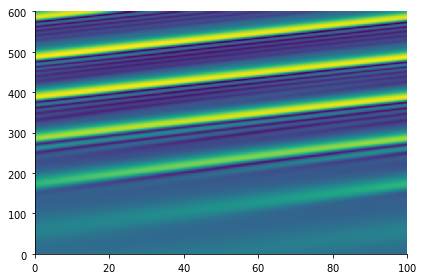

In [37]:
pl.pcolormesh(persist.x,
              persist.t,
              persist.h)
pl.show()

#### Calcul de la vitesse de propagation de l'onde

In [38]:
dt = np.median(np.gradient(persist.t))
celerities = np.gradient(persist.x[np.argmax(persist.h[persist.t > 400], axis=1)]) / dt
# On élimine les valeurs aberantes, quand la vague passe d'un côté à l'autre du domaine
celerities = celerities[celerities > 0]
c = np.median(celerities)
print(f"Vitesse de propagation de l'onde (établie): {c:g}")

Vitesse de propagation de l'onde (établie): 1.00083


#### Calcul des champs de vitesses et de la fonction de courant

In [39]:
yb = np.linspace(0, 1, 100)

def velocity(q, h, yb):
    return (3 * q / h
            * (yb - 1/2 * yb**2))

xx, yyb = np.meshgrid(persist.x, yb, indexing='ij')
yy = yyb * persist.h[-1][:, np.newaxis]
triangles = Triangulation(xx.flatten(), yyb.flatten())
triangles.y = (triangles.y.reshape(xx.shape) *
               persist.h[-1][:, np.newaxis]).flatten()

q = np.repeat(persist.q[-1][:, np.newaxis], yb.size, axis=1)
h = np.repeat(persist.h[-1][:, np.newaxis], yb.size, axis=1)
u = velocity(q, h, yyb) - c
v = -cumtrapz(y=(np.gradient(u, axis=0) / 
                 np.gradient(persist.x)[:, np.newaxis]),
              x=yy,
              initial=0,
              axis=1)
stream = cumtrapz(y=u, x=yy,
                  axis=1, initial=0)

#### Affichage des composantes du champs de vitesse et des lignes de courant

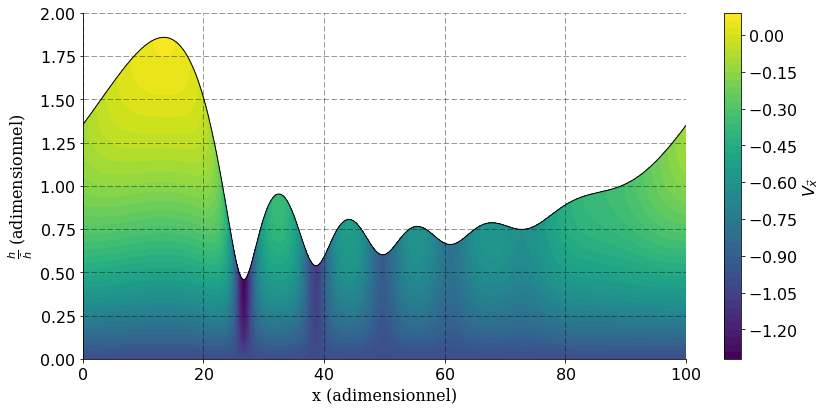

In [40]:
pl.figure(figsize=(12, 6))
with pl.rc_context(rc={'text.fontsize': 16}):
    pl.tricontourf(triangles, u.flatten(), 50)
    pl.plot(persist.x, persist.h[-1], color='black')
    pl.xlim(persist.x.min(), persist.x.max())
    pl.ylim(0, 2)
    pl.xlabel('x (adimensionnel)')
    pl.ylabel(r"$\frac{h}{\bar{h}}$ (adimensionnel)")
    cbar = pl.colorbar()
    cbar.set_label(r'$V_{\vec{x}}$')
    pl.show()
    # pl.savefig('figures/01-established_wave_Vx.pdf')

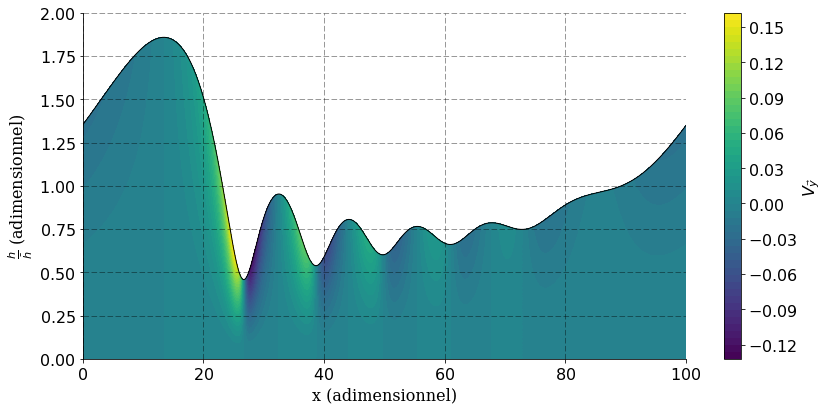

In [11]:
pl.figure(figsize=(12, 6))
with pl.rc_context(rc={'text.fontsize': 16}):
    pl.tricontourf(triangles, v.flatten(), 50)
    pl.plot(persist.x, persist.h[-1], color='black')
    pl.xlim(persist.x.min(), persist.x.max())
    pl.ylim(0, 2)
    pl.xlabel('x (adimensionnel)')
    pl.ylabel(r"$\frac{h}{\bar{h}}$ (adimensionnel)")
    cbar = pl.colorbar()
    cbar.set_label(r'$V_{\vec{y}}$')
    # pl.savefig('figures/01-established_wave_Vy.pdf')
    pl.show()

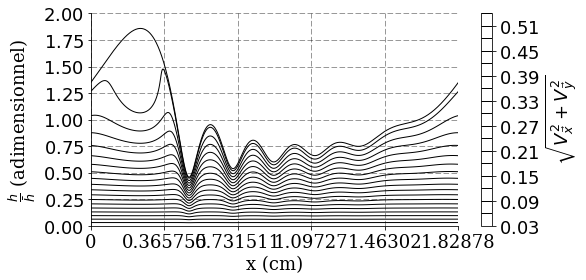

In [25]:
pl.figure(figsize=(33 / 4, 4))
with pl.rc_context(rc={'text.fontsize': 18}):
    pl.tricontour(triangles, np.abs(stream.flatten()), 20,
                  colors='black', linestyles='-')
    # pl.tripcolor(triangles, np.sqrt(u**2 + v**2).flatten(), cmap='viridis_r')
    pl.plot(persist.x, persist.h[-1], color='black')
    pl.xlabel('x (cm)')
    pl.ylabel(r"$\frac{h}{\bar{h}}$ (adimensionnel)")
    pl.xlim(persist.x.min(), persist.x.max())
    pl.ylim(0, 2)
    locs, labels = pl.xticks()

    cbar = pl.colorbar()
    cbar.set_label(r'$\sqrt{V_{\vec{x}}^2 + V_{\vec{y}}^2}$')
    pl.savefig('figures/01-established_wave_streamlines.pdf')

(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text xticklabel objects>)

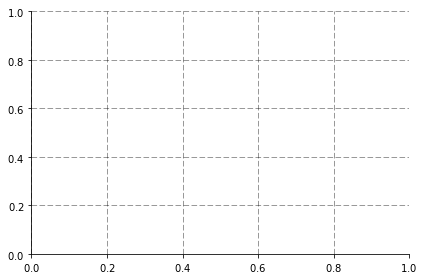

## Couplage thermique

### Modèle

In [ ]:
func = ["-dxq",
        """((378 * dxxq * h**2 +
           336 * dxh**2 * q - 210 * (q + 2 * dxs**2 * q) -
           9 * h * q * (56 * dxxh + 35 * dxxs + 68 * dxq * Re) -
           2 * dxh * (189 * dxq * h + 35 * Ct * h**3 +
                      3 * q * (35 * dxs - 54 * q * Re)) +
           70 * h**3 * (1 - Ct * dxs +
                        (dxxxh + dxxxs) * We)) / (252. * h**2 * Re))""",
        """(-(2*dxh*(1 + B*h)*
                (-7*(3*dxphi + 4*dxtheta)*h*(1 + B*h)**2 +
                                 15*dxs*(-16 - 3*phi -
                                         3*B*h*(2 + B*h)*(5 + phi)) +
                                 48*dxs*(1 + B*h)**2*(5 + 2*B*h)*theta) +
         2*dxh**2*(-3*(30 + 7*phi) -
                   B*h*(250 + 63*phi +
                        3*B*h*(3 + B*h)*(27 + 7*phi)) +
                   6*(1 + B*h)**3*(15 + 8*B*h)*theta) +
         (1 + B*h)*(-6*dxs*(15*dxphi +
                            8*dxtheta)*h*(1 + B*h)**2 -
         24*(15 + 30*B*h + 7*phi - 15*theta) +
         24*(dxs + B*dxs*h)**2*(-15 - 7*phi +
                                (15 + 4*B*h)*theta) +
            h*(-360*B**2*h -
               dxxh*(68 + 3*B*h*(41 + 19*B*h)) -
               (1 + B*h)*(34*dxxtheta*h*(1 + B*h) +
                          dxxs*(72 + 57*B*h)) -
               3*(7*dxxh + 15*dxxs + B*(2 + B*h)*(56 +
                7*dxxh*h + 15*dxxs*h))*phi +
               153*dxtheta*(1 + B*h)**2*Pe*q +
               4*(17*dxxh + 18*dxxs +
                  B*(228 + h*(186*B + 34*dxxh +
                              36*dxxs + B*(48*B +
                                           17*dxxh +
                                           18*dxxs)*h)))*theta)))/
    (102.*h**2*(1 + B*h)**3*Pe))""",
        """((2*dxh**2*(-3*(5 + 6*B*h)*(8 +
     B*h*(13 + 6*B*h)) - 28*(1 +
     B*h)**3*phi + 30*(1 + B*h)**3*(4 +
     B*h)*theta) +
         2*dxh*(1 + B*h)*(-((11*dxphi +
          60*dxtheta)*h*(1 + B*h)**2) +
         20*dxs*(-16 - 3*phi - 3*B*h*(2 +
                                      B*h)*(5 + phi) +
         (1 + B*h)**2*(16 + 3*B*h)*theta)) +
         (1 + B*h)*(-480 + 40*dxxs*h +
                    17*dxxphi*h**2 - 40*dxs*(3*dxphi +
                                             5*dxtheta)*h*(1 + B*h)**2 -
                    360*phi - 11*dxxh*h*phi -
                    60*dxxs*h*phi - 51*dxq*Pe*phi +
                    480*theta - 40*dxxs*h*theta +
                    120*B**3*h**3*theta +
            60*(dxs +
            B*dxs*h)**2*(-8 - 6*phi +
                               (8 + B*h)*theta) +
                                B**2*h**2*(-480 +
                                           17*dxxphi*h**2 +
                                           dxxh*h*(9 - 11*phi) -
                                           360*phi - 51*dxq*Pe*phi +
                                           720*theta -
                                           20*dxxs*h*(-3 +
                                                      3*phi + 2*theta)) +
            2*B*h*(dxxh*h*(3 - 11*phi) +
                   17*(dxxphi*h**2 - 3*dxq*Pe*phi) -
                   60*(8 + 6*phi - 9*theta) -
                   10*dxxs*h*(-5 + 6*phi + 4*theta))))/
    (51.*h*(1 + B*h)**3*Pe))"""
        ]
var = ["h", "q", "theta", "phi"]
pars = ["Re", "Ct", "We", "B", "Pe"]
fields = "s"
thermal_model = tf.Model(func, var, pars, fields)

### Conditions initiales

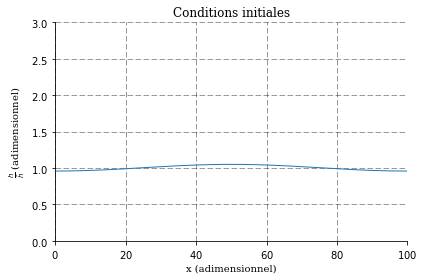

In [18]:
x = np.linspace(0, 100, 1200)
h = helpers.make_initial_wave(x, .1, 1)

q = h ** 3 / 3
theta = x * 0 + 1
phi = x * 0
init_fields = thermal_model.fields_template(x=x, h=h, q=q,
                                            theta=theta, phi=phi, s=x*0)

parameters = materials.water()
parameters['Re'] = 20
parameters['Ct'] = 0
parameters['Bi'] = .1
parameters['periodic'] = True

pl.plot(x, h)
pl.xlim(x.min(), x.max())
pl.ylim(0, 3)
pl.legend()
pl.title('Conditions initiales')
pl.xlabel('x (adimensionnel)')
pl.ylabel(r"$\frac{h}{\bar{h}}$ (adimensionnel)")
pl.show()

### Lancement de la simulation

In [19]:
t = 0
fields = init_fields

simul = tf.Simulation(thermal_model, t, fields, parameters, dt=1, tol=1E-1,
                      tmax=600)

simul.add_display(tf.displays.bokeh_fields_update, ['h', 'theta'],
                  fig_kwargs={"h":
                              {"width": 600,
                               "height": 200,
                               "x_range": (x.min(), x.max()),
                               "y_range": (0, 3)},
                              "theta":
                              {"width": 600,
                                "height": 200,
                                "x_range": (x.min(), x.max())}})

persist = container.TreantContainer('data/periodic_wave_thermal',
                                    initial_fields=init_fields,
                                    metadata=parameters,
                                    clean=True)
for t, fields in simul:
    persist.append(t, fields)
    print(f"{t:g}".ljust(80), end='\r')

Loading BokehJS ...

### Post traitement

In [109]:
persist = container.TreantContainer('data/periodic_wave_thermal')

#### Graphe spatio-temporel

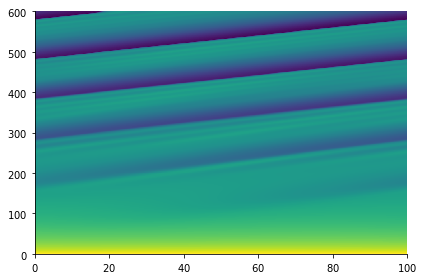

In [110]:
pl.pcolormesh(persist.x,
              persist.t,
              persist.theta)
pl.show()

#### Calcul de la vitesse de propagation de l'onde

In [111]:
dt = np.median(np.gradient(persist.t))
celerities = np.gradient(persist.x[np.argmax(persist.h[persist.t > 400], axis=1)]) / dt
# On élimine les valeurs aberantes, quand la vague passe d'un côté à l'autre du domaine
celerities = celerities[celerities > 0]
c = np.median(celerities)
print(f"Vitesse de propagation de l'onde (établie): {c:g}")

Vitesse de propagation de l'onde (établie): 1.00083


#### Calcul des champs de vitesses et de la fonction de courant et de la température

In [112]:
yb = np.linspace(0, 1, 100)

def velocity(q, h, yb):
    return (3 * q / h
            * (yb - 1/2 * yb**2))

def temperature(q, h, theta, phi, B, yb):
    return (yb**2 * (theta - 1 / (B * h + 1)) 
            + (- 1 / (B * h + 1) + phi + 1)
               * (yb**3 / 2 - 3 * yb**2 / 2 + yb)
            + (B * h - B * yb * h + 1) / (B * h + 1))

xx, yyb = np.meshgrid(persist.x, yb, indexing='ij')
yy = yyb * persist.h[-1][:, np.newaxis]
triangles = Triangulation(xx.flatten(), yyb.flatten())
triangles.y = (triangles.y.reshape(xx.shape) *
               persist.h[-1][:, np.newaxis]).flatten()

q = np.repeat(persist.q[-1][:, np.newaxis], yb.size, axis=1)
h = np.repeat(persist.h[-1][:, np.newaxis], yb.size, axis=1)
theta = np.repeat(persist.theta[-1][:, np.newaxis], yb.size, axis=1)
phi = np.repeat(persist.phi[-1][:, np.newaxis], yb.size, axis=1)

u = velocity(q, h, yyb) - c
v = -cumtrapz(y=(np.gradient(u, axis=0) / 
                 np.gradient(persist.x)[:, np.newaxis]),
              x=yy,
              initial=0,
              axis=1)
stream = cumtrapz(y=u, x=yy,
                  axis=1, initial=0)
T = temperature(q, h, theta, phi, persist['B'], yyb)

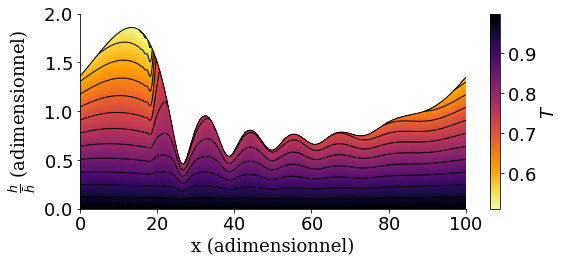

In [123]:
pl.figure(figsize=(33 / 4, 4))
with pl.rc_context(rc={'text.fontsize': 18}):
    pl.tricontour(triangles, T.flatten(), 15, colors='black')
    pl.tripcolor(triangles, T.flatten(), cmap='inferno_r')
    pl.plot(fields.x, fields.h, color='black')
    pl.xlim(fields.x.min(), fields.x.max())
    pl.ylim(0, 2)
    pl.xlabel('x (adimensionnel)')
    pl.ylabel(r"$\frac{h}{\bar{h}}$ (adimensionnel)")
    cbar = pl.colorbar()
    cbar.set_label(r'$T$')
    pl.savefig('figures/01-established_wave_T.pdf')
    pl.show()

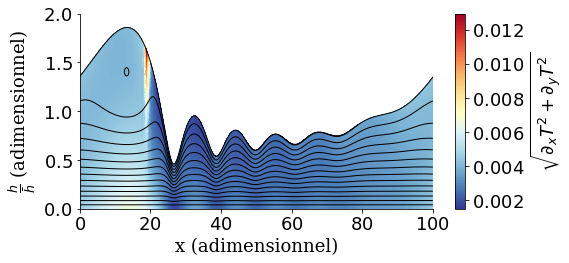

In [126]:
pl.figure(figsize=(33 / 4, 4))
with pl.rc_context(rc={'text.fontsize': 18}):
    pl.tricontour(triangles, np.abs(stream.flatten()), 15,
                  colors='black', linestyles='-')
    dT = np.gradient(T)
    pl.tripcolor(triangles, np.sqrt(dT[0]**2 + dT[1]**2).flatten(),
                 cmap='RdYlBu_r')
    pl.plot(fields.x, fields.h, color='black')
    pl.xlim(fields.x.min(), fields.x.max())
    pl.ylim(0, 2)
    pl.xlabel('x (adimensionnel)')
    pl.ylabel(r"$\frac{h}{\bar{h}}$ (adimensionnel)")
    cbar = pl.colorbar()
    cbar.set_label(r"$\sqrt{\partial_x T ^ 2 + \partial_y T^2}$")
    pl.savefig('figures/01-established_wave_Tmag_streamlines.pdf')
    pl.show()

## Effet de la fréquence de forçage - hydrodynamique

### Conditions initiales

In [ ]:
parameters = materials.water()
parameters['Re'] = 5
parameters['Ct'] = 0
parameters['periodic'] = False

x = np.linspace(0, 40E-2 * parameters['l_factor'], 4000)
h = x * 0 + 1

q = h ** 3 / 3
init_fields = hydro_model.fields_template(x=x, h=h, q=q, s=x*0)

pl.plot(x, h)
pl.xlim(x.min(), x.max())
pl.ylim(0, 3)
pl.legend()
pl.title('Conditions initiales')
pl.xlabel('x (adimensionnel)')
pl.ylabel(r"$\frac{h}{\bar{h}}$ (adimensionnel)")
pl.show()

### Lancement des simulations

In [ ]:
def run_simul(freq):
    with open(log_path, 'a') as log_file:
        print(f'init_simul {freq:02d}Hz', file=log_file)
        t = 0
        fields = init_fields
        adim_freq = freq / parameters['t_factor']

        noisy = tf.signals.GaussianBrownNoise(100, frequency_cut=50)
        forced = tf.signals.SinusoidalSignal(adim_freq, amplitude=.1)

        def forced_frequency_hook(t, fields, parameters):
            fields.h[0] = noisy(t) * .1 + forced(t) + 1
            fields.q[0] = fields.h[0] ** 3 / 3
            return fields, parameters

        simul = tf.Simulation(hydro_model, t, fields, parameters, dt=10, tol=5E-1,
                              hook=forced_frequency_hook, tmax=6000)
        persist = container.TreantContainer('data/forced_freq/%02d_Hz' % freq,
                                            metadata=parameters,
                                            clean=True)
        log_path = Path(f"log/pid_{mp.current_process().pid}.log")

        for t, fields in simul:
            print(f"{freq:02d}Hz: \t{t:g}".ljust(80), file=log_file)
            log_file.flush()
        persist.set(t, fields)
        print(f"end simul {freq:02d}Hz", file=log_file)

In [ ]:
res_path = Path("data/forced_freq/")
res_path.rmtree_p()
log_path = Path("log/")
log_path.rmtree_p()
log_path.mkdir_p()
with mp.Pool(6) as p:
    p.map(run_simul, np.arange(1, 25))

In [ ]:
full_h = []
for freq in np.arange(1, 25):
    persist = container.TreantContainer('data/forced_freq/%02d_Hz' % freq)
    full_h.append(persist.h[-1])
full_h = np.vstack(full_h)

In [ ]:
with pl.rc_context(rc={"axes.xmargin": 0,
                       "axes.ymargin": 0,
                       "text.fontsize": 18,
                       "axes.grid": False}):
    pl.figure(figsize=(33 / 4, 6))
    cascade_plot(persist.x / persist.l_factor * 100, full_h, space_factor=.15, fill_color='darkred')
    pl.xlabel('x (cm)')
    pl.yticks(np.linspace(2, 20.3, 13), [f"{freq} Hz" for freq in np.arange(1, 26, 2)])
    pl.savefig('figures/01-frequency_effect.pdf')
    pl.show()

## Effet de la fréquence de forçage - thermique

### Conditions initiales

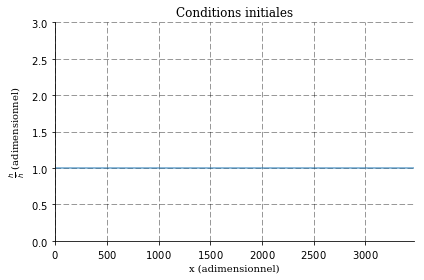

In [325]:
parameters = materials.water()
parameters['Re'] = 5
parameters['Ct'] = 0
parameters['Bi'] = .01
parameters['periodic'] = False

x = np.linspace(0, 40E-2 * parameters['l_factor'], 4000)
h = x * 0 + 1
q = h ** 3 / 3
theta = x * 0 + parameters['theta_flat']
phi = x * 0 + parameters['phi_flat']

init_fields = thermal_model.fields_template(x=x, h=h, q=q, theta=theta, phi=phi, s=x*0)

pl.plot(x, h)
pl.xlim(x.min(), x.max())
pl.ylim(0, 3)
pl.legend()
pl.title('Conditions initiales')
pl.xlabel('x (adimensionnel)')
pl.ylabel(r"$\frac{h}{\bar{h}}$ (adimensionnel)")
pl.show()

### Lancement des simulations

In [332]:
def run_simul(freq, display=False):
    print(f'init_simul {freq:02d}Hz')
    t = 0
    fields = init_fields
    adim_freq = freq / parameters['t_factor']

    noisy = tf.signals.GaussianBrownNoise(100, frequency_cut=50)
    forced = tf.signals.SinusoidalSignal(adim_freq, amplitude=.1)

    def forced_frequency_hook(t, fields, parameters):
        fields.h[0] = noisy(t) * .1 + forced(t) + 1
        fields.q[0] = fields.h[0] ** 3 / 3
        fields.theta[0] = parameters['theta_flat']
        fields.phi[0] = parameters['phi_flat']
        return fields, parameters

    simul = tf.Simulation(thermal_model, t, fields, parameters, dt=10, tol=5E-1,
                          hook=forced_frequency_hook, tmax=6000)
    if display:
        simul.add_display(tf.displays.bokeh_fields_update, ['h', 'theta'],
                  fig_kwargs={"h":
                              {"width": 600,
                               "height": 200,
                               "x_range": (x.min(), x.max()),
                               "y_range": (0, 3)},
                              "theta":
                              {"width": 600,
                                "height": 200,
                                "x_range": (x.min(), x.max())}})
    log_path = Path(f"log/pid_{mp.current_process().pid}.log")
    persist = container.TreantContainer('data/thermal_forced_freq/%02d_Hz' % freq,
                                        initial_fields=init_fields,
                                        metadata=parameters,
                                        clean=True)
    with open(log_path, 'a') as log_file:
        for t, fields in simul:
            print(f"{freq:02d}Hz: \t{t:g}".ljust(80), file=log_file)
            log_file.flush()
            persist.append(t, fields)
    print(f"end simul {freq:02d}Hz")

In [ ]:
res_path = Path("data/thermal_forced_freq/")
res_path.rmtree_p()
log_path = Path("log/")
log_path.rmtree_p()
log_path.mkdir_p()
with mp.Pool(8) as p:
    p.map(run_simul, np.arange(1, 25))

init_simul 03Hz
init_simul 02Hz
init_simul 06Hz
init_simul 05Hz
init_simul 08Hz
init_simul 04Hz
init_simul 01Hz
init_simul 07Hz


In [236]:
full_h = []
for freq in np.arange(1, 25):
    persist = container.TreantContainer('data/forced_freq/%02d_Hz' % freq)
    full_h.append(persist.h[-1])
full_h = np.vstack(full_h)

In [240]:
from scibelt.viz import cascade_plot

In [300]:
!echo "{"\n".join(list(pl.rcParamsDefault.keys()))}" | grep grid

axes.grid
axes.grid.axis
axes.grid.which
axes3d.grid
grid.alpha
grid.color
grid.linestyle
grid.linewidth
keymap.grid
polaraxes.grid


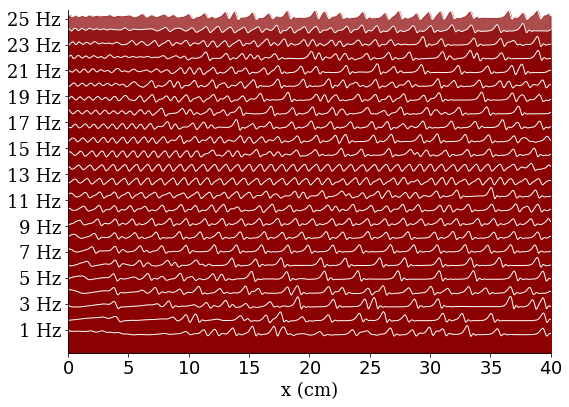

In [313]:
with pl.rc_context(rc={"axes.xmargin": 0,
                       "axes.ymargin": 0,
                       "text.fontsize": 18,
                       "axes.grid": False}):
    pl.figure(figsize=(33 / 4, 6))
    cascade_plot(persist.x / persist.l_factor * 100, full_h, space_factor=.15, fill_color='darkred')
    pl.xlabel('x (cm)')
    pl.yticks(np.linspace(2, 20.3, 13), [f"{freq} Hz" for freq in np.arange(1, 26, 2)])
    pl.savefig('figures/01-frequency_effect.pdf')
    pl.show()